In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [113]:
import numpy as np
import torch
import scanpy as sc
import muon as mu
import anndata
import mudata
import pandas as pd

print(anndata.__version__)
print(mudata.__version__)
print(sc.__version__)
print(torch.__version__)


0.8.0
0.2.1
1.9.2
1.11.0


In [212]:
sc.set_figure_params(scanpy=True, fontsize=14, figsize=[5, 5])

In [10]:
%load_ext autoreload
%autoreload 2

In [114]:
from src.types import TrainParams
from src.model import ModelParams
from src.smvae.model import SMVAE
from src.smvae.train import train_smvae
from src.smvae.dataloader import *
from src.smvae.diagnostics import plot_embedding, classification_performance

from src.mvae.model import MVAE
from src.mvae.train import train_mvae
from src.mvae.dataloader import setup_mudata
from src.mvae.diagnostics import plot_embedding, classification_performance

In [12]:
# mdata = mu.read('/media/yob/nacho_stuff/prostate_cancer/Integration/MVAE-PoE/OtF-prostate/data/mdata_preprocessed_final_filtered.h5mu')
# metadata = mu.read('/media/yob/nacho_stuff/prostate_cancer/Integration/MVAE-PoE/OtF-prostate/data/mdata_metadata.h5mu')
# mdata.obs["new_ann"] = metadata.obs["new_ann"]
# mdata.mod["msi"].obs["new_ann"] = metadata.obs["new_ann"]
# mdata.mod["rna"].obs["new_ann"] = metadata.obs["new_ann"]
# mdata
mdata = mu.read('/media/gambino/students_workdir/anna/OtF-prostate/data/mdata_out_smvae.h5mu')

In [13]:
mdata.obs["tissue_name"] = mdata.obs["tissue"].apply(lambda x: "Cancer" if x == "DLC2" else "Normal")

In [14]:
mdata.obs["cell_type"] = mdata.obs["new_ann"]

In [15]:
def sample_transl(x):
    patient = x.split("_")[0]
    status = x.split("_")[1]
    if status == "DLC2":
        return f"{patient}_cancer"
    return f"{patient}_normal"
mdata.obs["sample_name"] = mdata.obs["sample"].apply(lambda x: sample_transl(x))
mdata.obs["sample_name"]

304-929_cancer_20um     PWB929_cancer
1304-929_cancer_20um    PWB929_cancer
1522-929_cancer_20um    PWB929_cancer
163-929_cancer_20um     PWB929_cancer
347-929_cancer_20um     PWB929_cancer
                            ...      
2671-952_normal_10um    PWB952_normal
1517-952_normal_10um    PWB952_normal
57-952_normal_10um      PWB952_normal
2176-952_normal_10um    PWB952_normal
2224-952_normal_10um    PWB952_normal
Name: sample_name, Length: 42475, dtype: category
Categories (16, object): ['PWB929_normal', 'PWB929_cancer', 'PWB931_normal', 'PWB931_cancer', ..., 'PWB950_normal', 'PWB950_cancer', 'PWB952_normal', 'PWB952_cancer']

### Save output of all SMVAE models

In [185]:
models = {
    "smvae_beta0.01": "smvae_prostate_nolisi_fullshared_20230429-174252.pt",
    "smvae_beta0.001": "smvae_prostate_nolisi_beta0.001_20230512-195310.pt",
    "smvae_beta0.001_gamma0.0001": "smvae_prostate_lisi_poe_beta0.001_gamma0.0001_20230502-031102.pt",
    "smvae_beta0.001_gamma0.0003": "smvae_prostate_lisi_poe_beta0.001_gamma0.0003_20230503-151506.pt",
    "smvae_beta0.001_gamma0.0005": "smvae_prostate_lisi_poe_beta0.001_gamma0.0005_20230502-133449.pt",
    "smvae_beta0.001_gamma0.001": "smvae_prostate_lisi_poe_beta0.001_gamma0.001_20230502-001455.pt",
    "smvae_beta0.001_gamma0.01": "smvae_prostate_lisi_poe_beta0.001_20230430-012112.pt",
    "smvae_beta0.001_gamma0.0001_delta0.1": "smvae_prostate_lisi_private_beta0.001_gamma0.0001_delta0.1_20230502-170820.pt",
    "smvae_beta0.001_gamma0.0005_delta0.1": "smvae_prostate_lisi_private_beta0.001_gamma0.0005_delta0.1_20230503-015025.pt"
}

train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128)
model_params = ModelParams(beta=0.001, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)

In [155]:
torch.set_num_threads(16)

for m, file in {"smvae_beta0.001": "smvae_prostate_nolisi_beta0.001_20230512-195310.pt"}.items():
    print(m)
    model = SMVAE(mdata, model_params)
    model.load_state_dict(torch.load(f"vae_params/{file}"))
    from src.smvae.train import to_latent
    poe, rna_p, msi_p, rna_s, msi_s = to_latent(model, mdata, "sample", train_params)
    mdata.obsm[f"{m}_z1_s"] = np.vstack(rna_s)
    mdata.obsm[f"{m}_z2_s"] = np.vstack(msi_s)
    mdata.obsm[f"{m}_z1_p"] = np.vstack(rna_p)
    mdata.obsm[f"{m}_z2_p"] = np.vstack(msi_p)
    mdata.obsm[f"{m}_z"] = np.vstack([x.numpy() for x in poe])
    
    for layer in ["z1_s", "z2_s", "z1_p", "z2_p"]:
        sc.pp.neighbors(
            mdata, n_neighbors=5, use_rep=f"{m}_{layer}", key_added=f"{m}_neigh_{layer}"
        )
        sc.tl.umap(mdata, neighbors_key=f"{m}_neigh_{layer}")
        mdata.obsm[f"X_{m}_{layer}"] = mdata.obsm["X_umap"]
    
    sc.pp.neighbors(mdata, use_rep=f"{m}_z", n_neighbors=30)
    sc.tl.umap(mdata)
    mdata.obsm[f"X_{m}_z"] = mdata.obsm["X_umap"]


smvae_beta0.001
(42475, 18950)
(42475, 12510)


100%|█████████████████████████████████████████| 332/332 [00:31<00:00, 10.52it/s]


In [156]:
mdata.write('/media/gambino/students_workdir/anna/OtF-prostate/data/mdata_out_smvae.h5mu')

smvae_beta0.001


/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


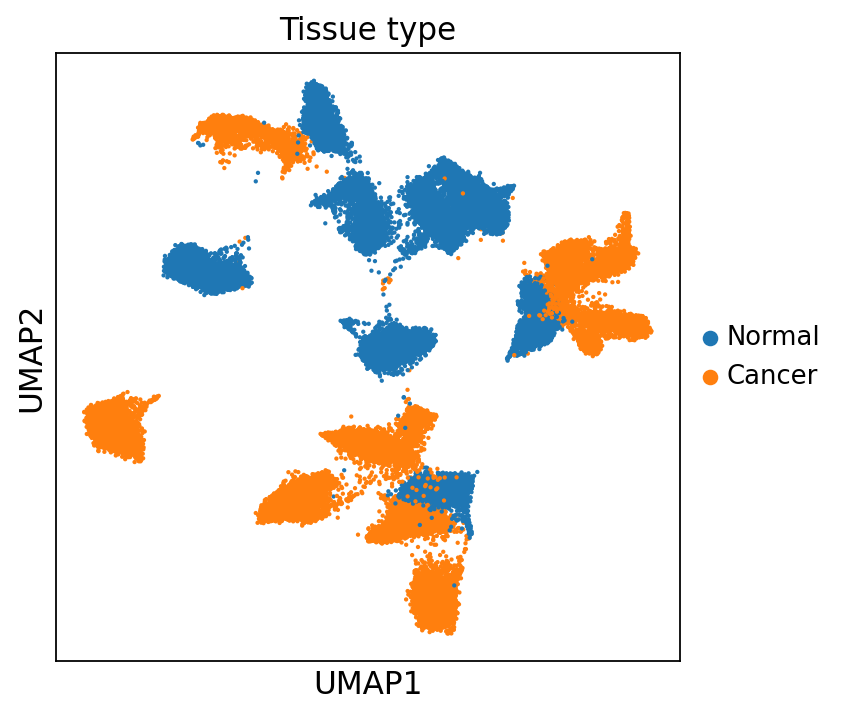

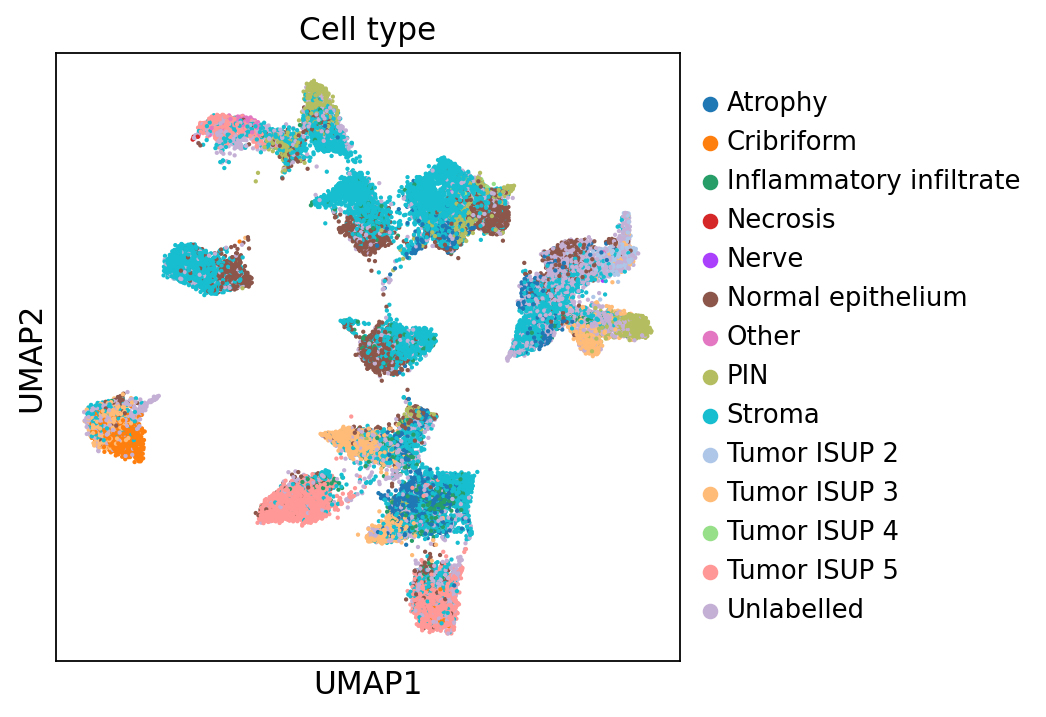

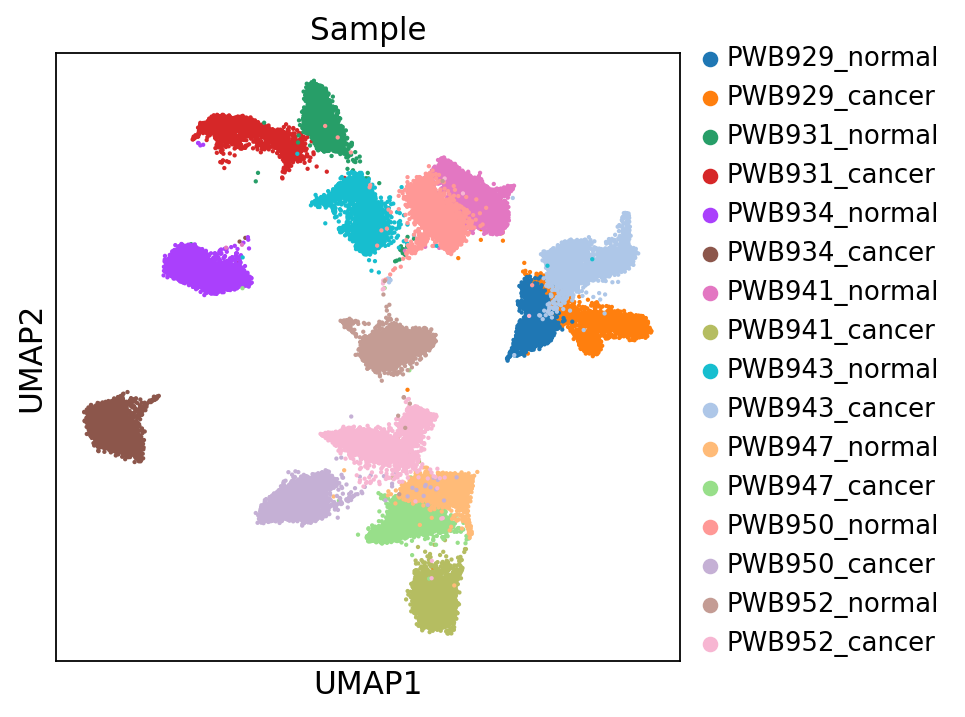

In [213]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

m = "smvae_beta0.001"
print(m)

# ["#3976AF", "#F08536", "#4F9B6C", "#C53A32", "#9D50F3", "#84584E", "#D57FBE", "#B6BC6D", "#56BBCC", "#B3C7E5", "#F6BD82", "#A8DC93", "#F19D99", "#C2B2D2"]
ax = sc.pl.embedding(mdata, f"X_{m}_z", color="tissue_name", show=False, title="Tissue type", legend_fontsize="small", size=15)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")


ax2 = sc.pl.embedding(mdata, f"X_{m}_z", color="cell_type", show=False, title="Cell type", legend_fontsize="small", size=15)
ax2.set_xlabel("UMAP1")
ax2.set_ylabel("UMAP2")

ax3 = sc.pl.embedding(mdata, f"X_{m}_z", color="sample_name", show=False, title="Sample", legend_fontsize="x-small", size=15) 
ax3.set_xlabel("UMAP1")
ax3.set_ylabel("UMAP2")
ax3.legend(ncol=1, fontsize="small", bbox_to_anchor=(1, 1.05), frameon=False)

## RNA private change

smvae_beta0.001 smvae_beta0.001_gamma0.0001 smvae_beta0.001_gamma0.001


/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Sample'}, xlabel='X_smvae_beta0.001_gamma0.01_z1_p1', ylabel='X_smvae_beta0.001_gamma0.01_z1_p2'>

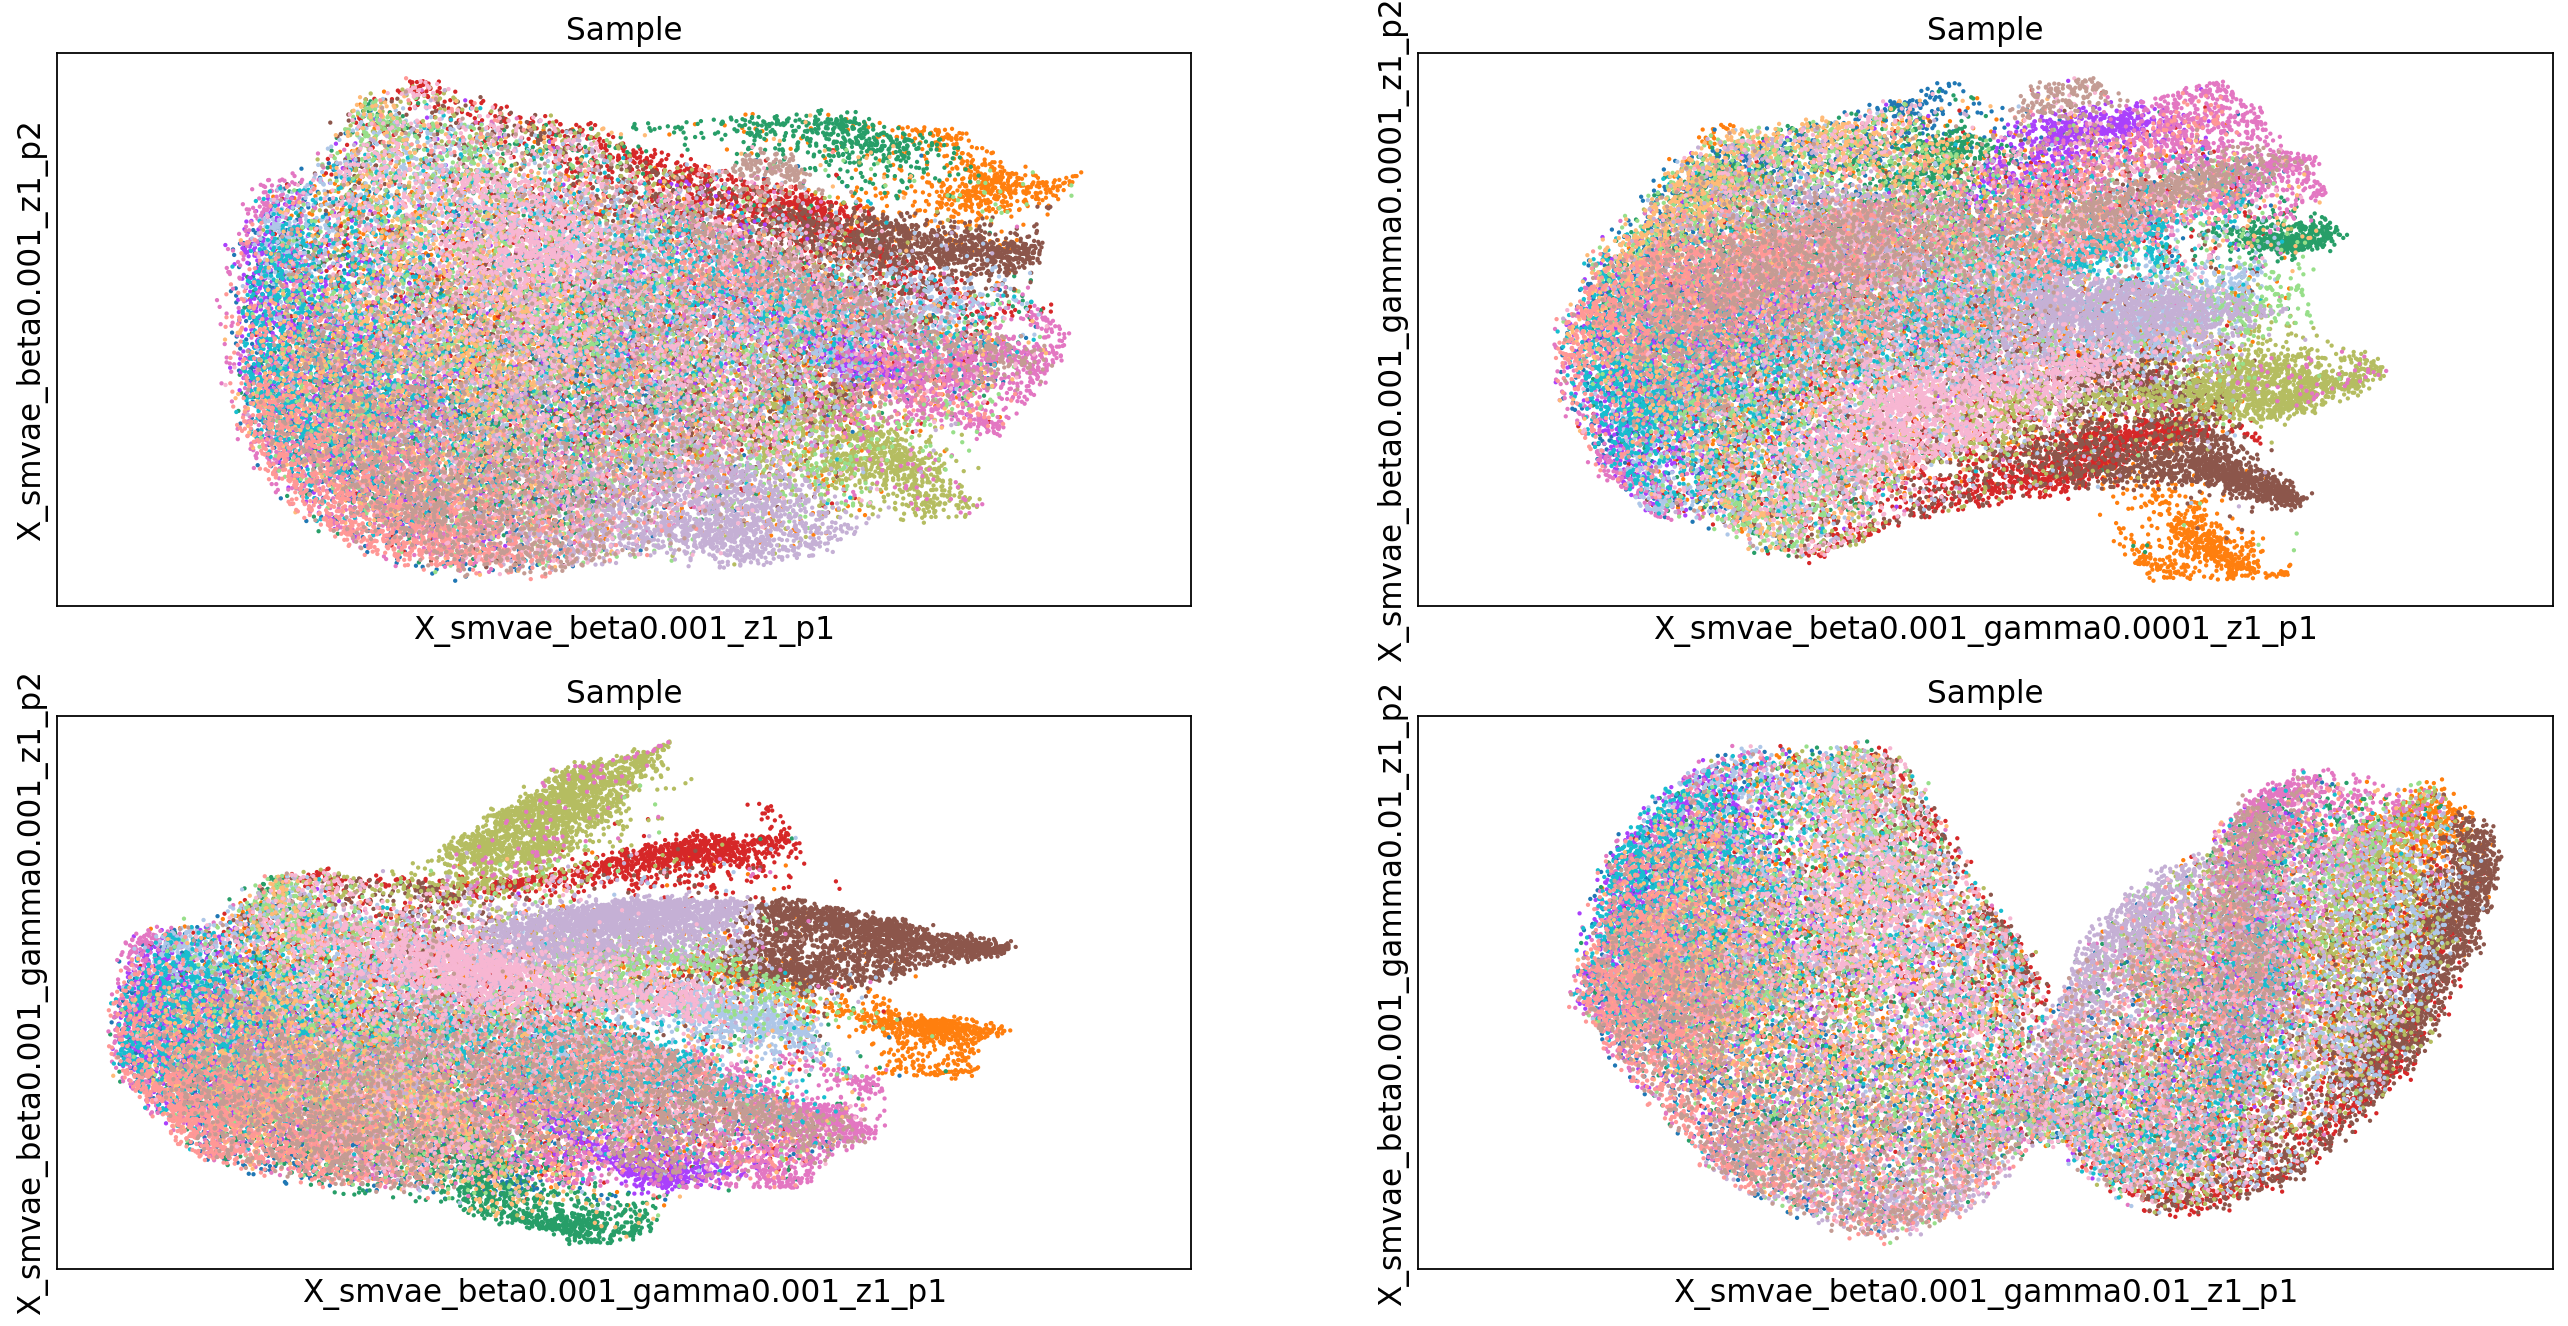

In [173]:
m1 = "smvae_beta0.001"
m2 = "smvae_beta0.001_gamma0.0001"
m3 = "smvae_beta0.001_gamma0.001"
m4 = "smvae_beta0.001_gamma0.01"
print(m1, m2, m3)

fig, axes = plt.subplots(2, 2, sharex=True, figsize=[20, 10])

sc.pl.embedding(mdata, f"X_{m1}_z1_p", ax=axes[0][0], color="sample_name", show=False, title="Sample", legend_loc=None, size=15)

sc.pl.embedding(mdata, f"X_{m2}_z1_p", ax=axes[0][1], color="sample_name", show=False, title="Sample", legend_loc=None, size=15)

sc.pl.embedding(mdata,  f"X_{m3}_z1_p",ax=axes[1][0], color="sample_name", show=False, title="Sample", legend_loc=None, size=15)

sc.pl.embedding(mdata,  f"X_{m4}_z1_p",ax=axes[1][1], color="sample_name", show=False, title="Sample", legend_loc=None, size=15) 

## Shared change

smvae_beta0.001 smvae_beta0.001_gamma0.0001 smvae_beta0.001_gamma0.0003


/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


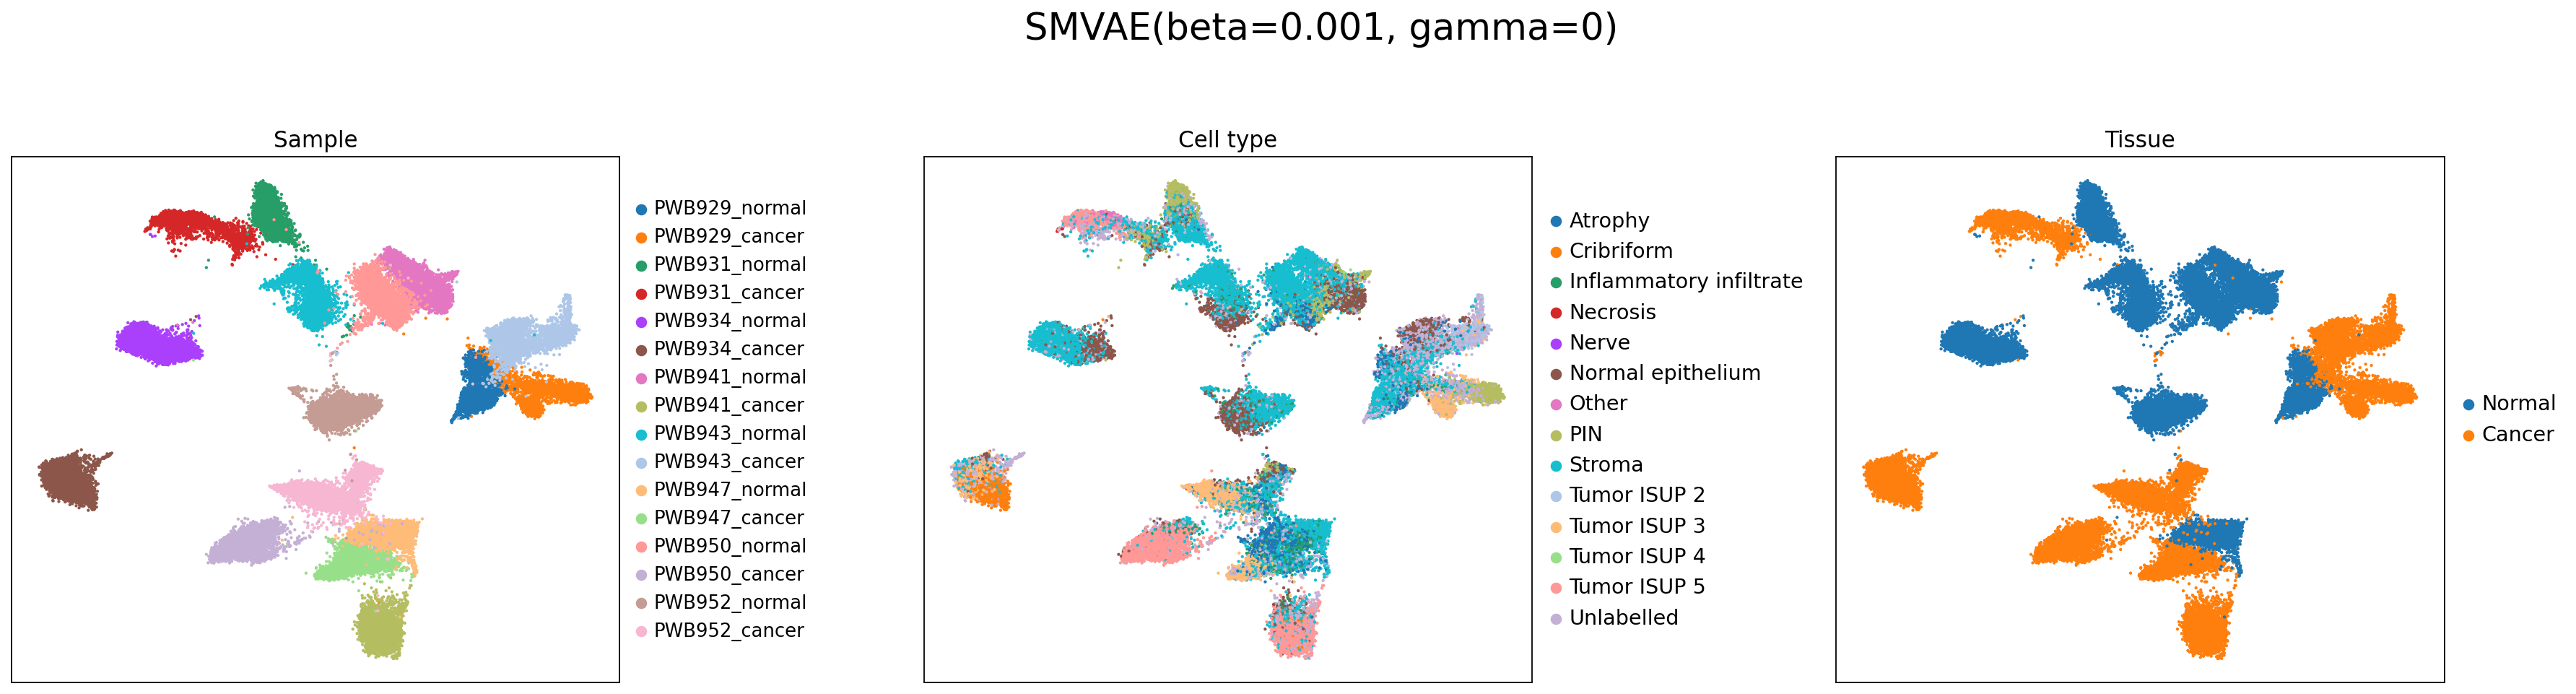

In [259]:
m1 = "smvae_beta0.001"
m2 = "smvae_beta0.001_gamma0.0001"
m3 = "smvae_beta0.001_gamma0.0003"
m4 = "smvae_beta0.001_gamma0.0005"
print(m1, m2, m3)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=[27, 7])
fig.subplots_adjust(wspace=0.5, top=0.8)
fig.suptitle("SMVAE(beta=0.001, gamma=0)", fontsize=23, x=0.6)
sc.pl.embedding(mdata, f"X_{m1}_z", ax=axes[0], color="sample_name", show=False, title="Sample", size=15)

sc.pl.embedding(mdata, f"X_{m1}_z", ax=axes[1], color="cell_type", show=False, title="Cell type", size=15)

sc.pl.embedding(mdata,  f"X_{m1}_z",ax=axes[2], color="tissue_name", show=False, title="Tissue", size=15)
axes[0].legend(ncol=1, fontsize="small", bbox_to_anchor=(1, 0.95), frameon=False)
for ax in axes:
    ax.set_ylabel("")
    ax.set_xlabel("")
plt.savefig("test.png", bbox_inches="tight", pad_inches=0.5)
# sc.pl.embedding(mdata,  f"X_{m4}_z",ax=axes[1][1], color="sample_name", show=False, title="Sample", legend_loc=None, size=15) 

In [7]:
rna = mdata.mod["rna"]
sc.pp.neighbors(rna, n_neighbors=30)
sc.tl.umap(rna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


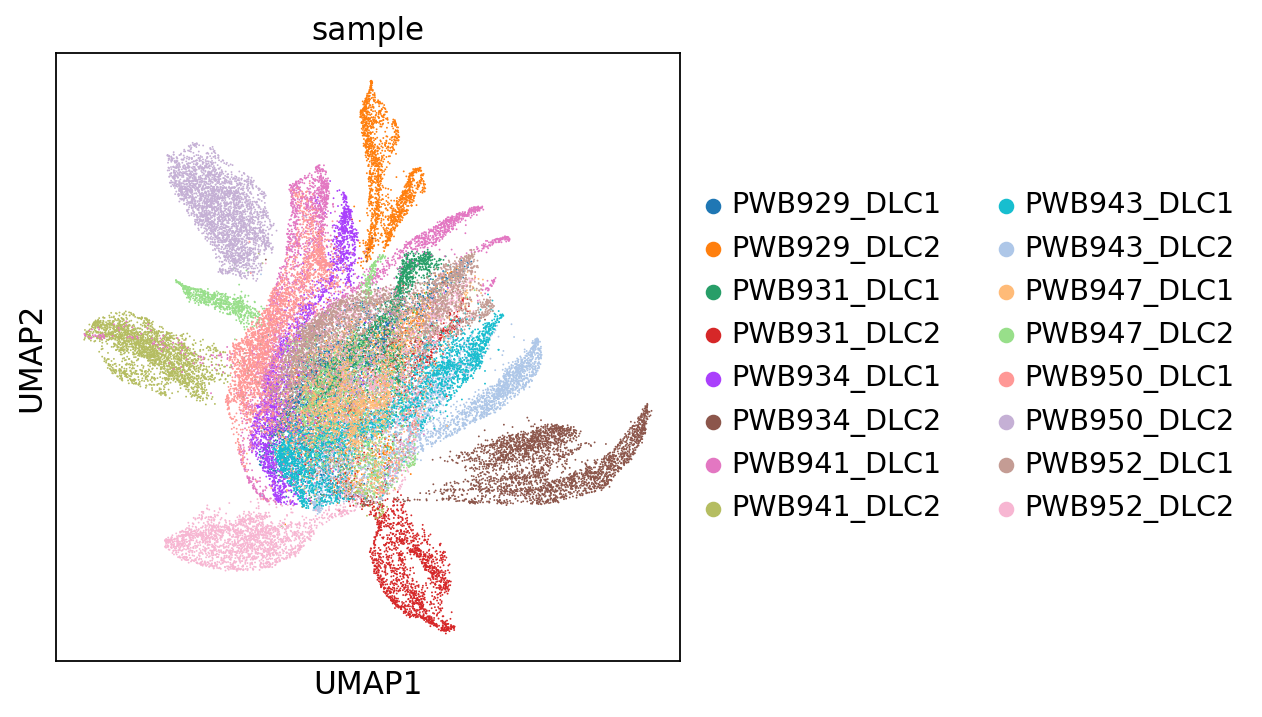

In [27]:
sc.pl.umap(rna, color=["sample"])

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


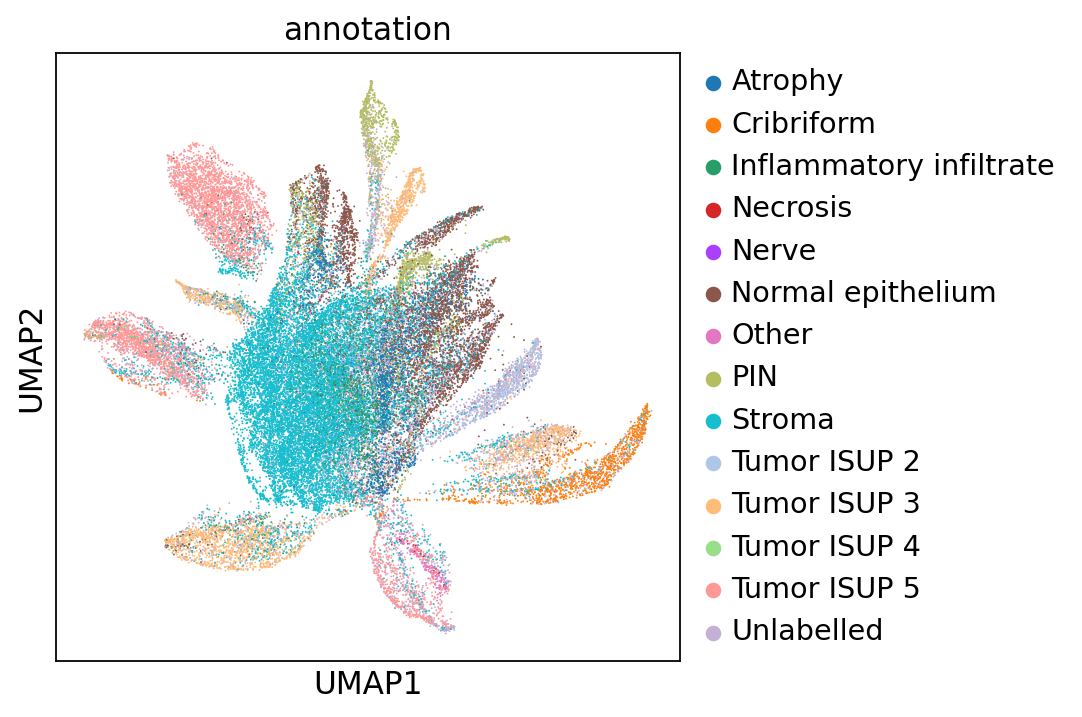

In [28]:
sc.pl.umap(rna, color=["new_ann"], title="annotation")

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


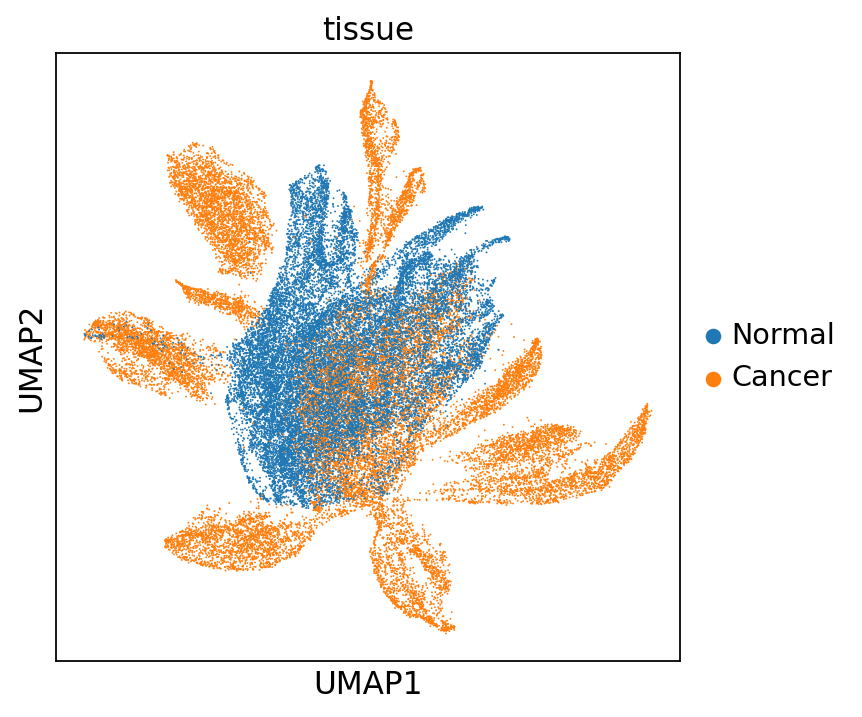

In [29]:
sc.pl.umap(rna, color=["tissue_name"], title="tissue")

In [30]:
msi = mdata.mod["msi"]
sc.pp.neighbors(msi, n_neighbors=30)
sc.tl.umap(msi)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [31]:
msi.obs["tissue_name"] = mdata.obs["tissue_name"]

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


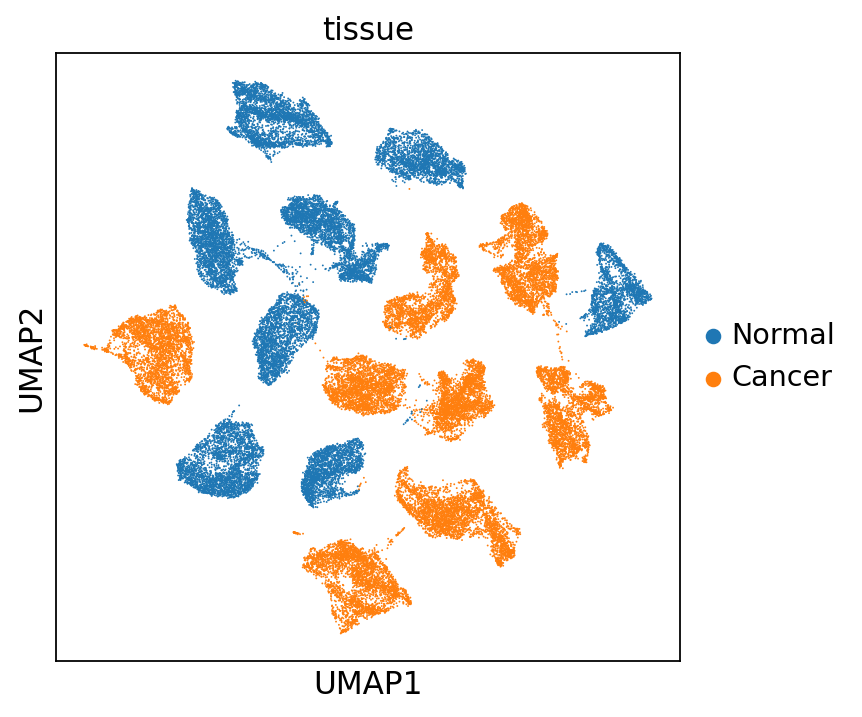

In [36]:
sc.pl.umap(msi, color=["tissue_name"], title="tissue")

## Logs

In [105]:
from src.utils import get_loss_logs, make_plot

In [186]:
model = models["smvae_beta0.001"]

In [187]:
runlog_data = get_loss_logs(model)
runlog_data.head()

step PoE_training/total_loss PoE_training/private PoE_training/shared  \
0     0               14.478992              4.82584            9.653152   
1     1                14.30624             4.770343            9.535896   
2     2               14.323019             4.773867            9.549151   
3     3               14.142189               4.7101            9.432089   
4     4               14.031739             4.675331            9.356408   

  PoE_training/rna_mse PoE_training/msi_mse PoE_training/recovered_rna_poe  \
0             0.777075             4.047931                       0.777045   
1             0.742093             4.027405                       0.743484   
2              0.73524             4.037764                       0.735795   
3             0.740909              3.96832                       0.741064   
4             0.719369             3.955086                       0.719296   

  PoE_training/recovered_msi_poe PoE_training/loss_msi_rna  \
0                       4.050018                  4.048148   
1                       4.024255                  4.024681   
2                       4.039047                  4.036516   
3                       3.974863                  3.974684   
4                       3.957425                  3.959108   

  PoE_training/loss_rna_msi PoE_training/kl PoE_training/kl_rna_p  \
0                  0.777664        0.000276              0.000209   
1                  0.743199        0.000278              0.000216   
2                  0.737513         0.00028              0.000222   
3                  0.741199        0.000279              0.000229   
4                  0.720297        0.000281              0.000228   

  PoE_training/kl_msi_p PoE_training/kl_rna_s PoE_training/kl_msi_s  \
0              0.000198              0.000204              0.000223   
1              0.000195              0.000211              0.000223   
2              0.000201              0.000215              0.000225   
3              0.000201              0.000214              0.000226   
4              0.000203              0.000221              0.000224   

  PoE_test/Test loss PoE_test/batch_integration_loss  
0           3.104877                             0.0  
1           2.480936                             0.0  
2           2.285402                             0.0  
3           2.087426                             0.0  
4           1.977356                             0.0

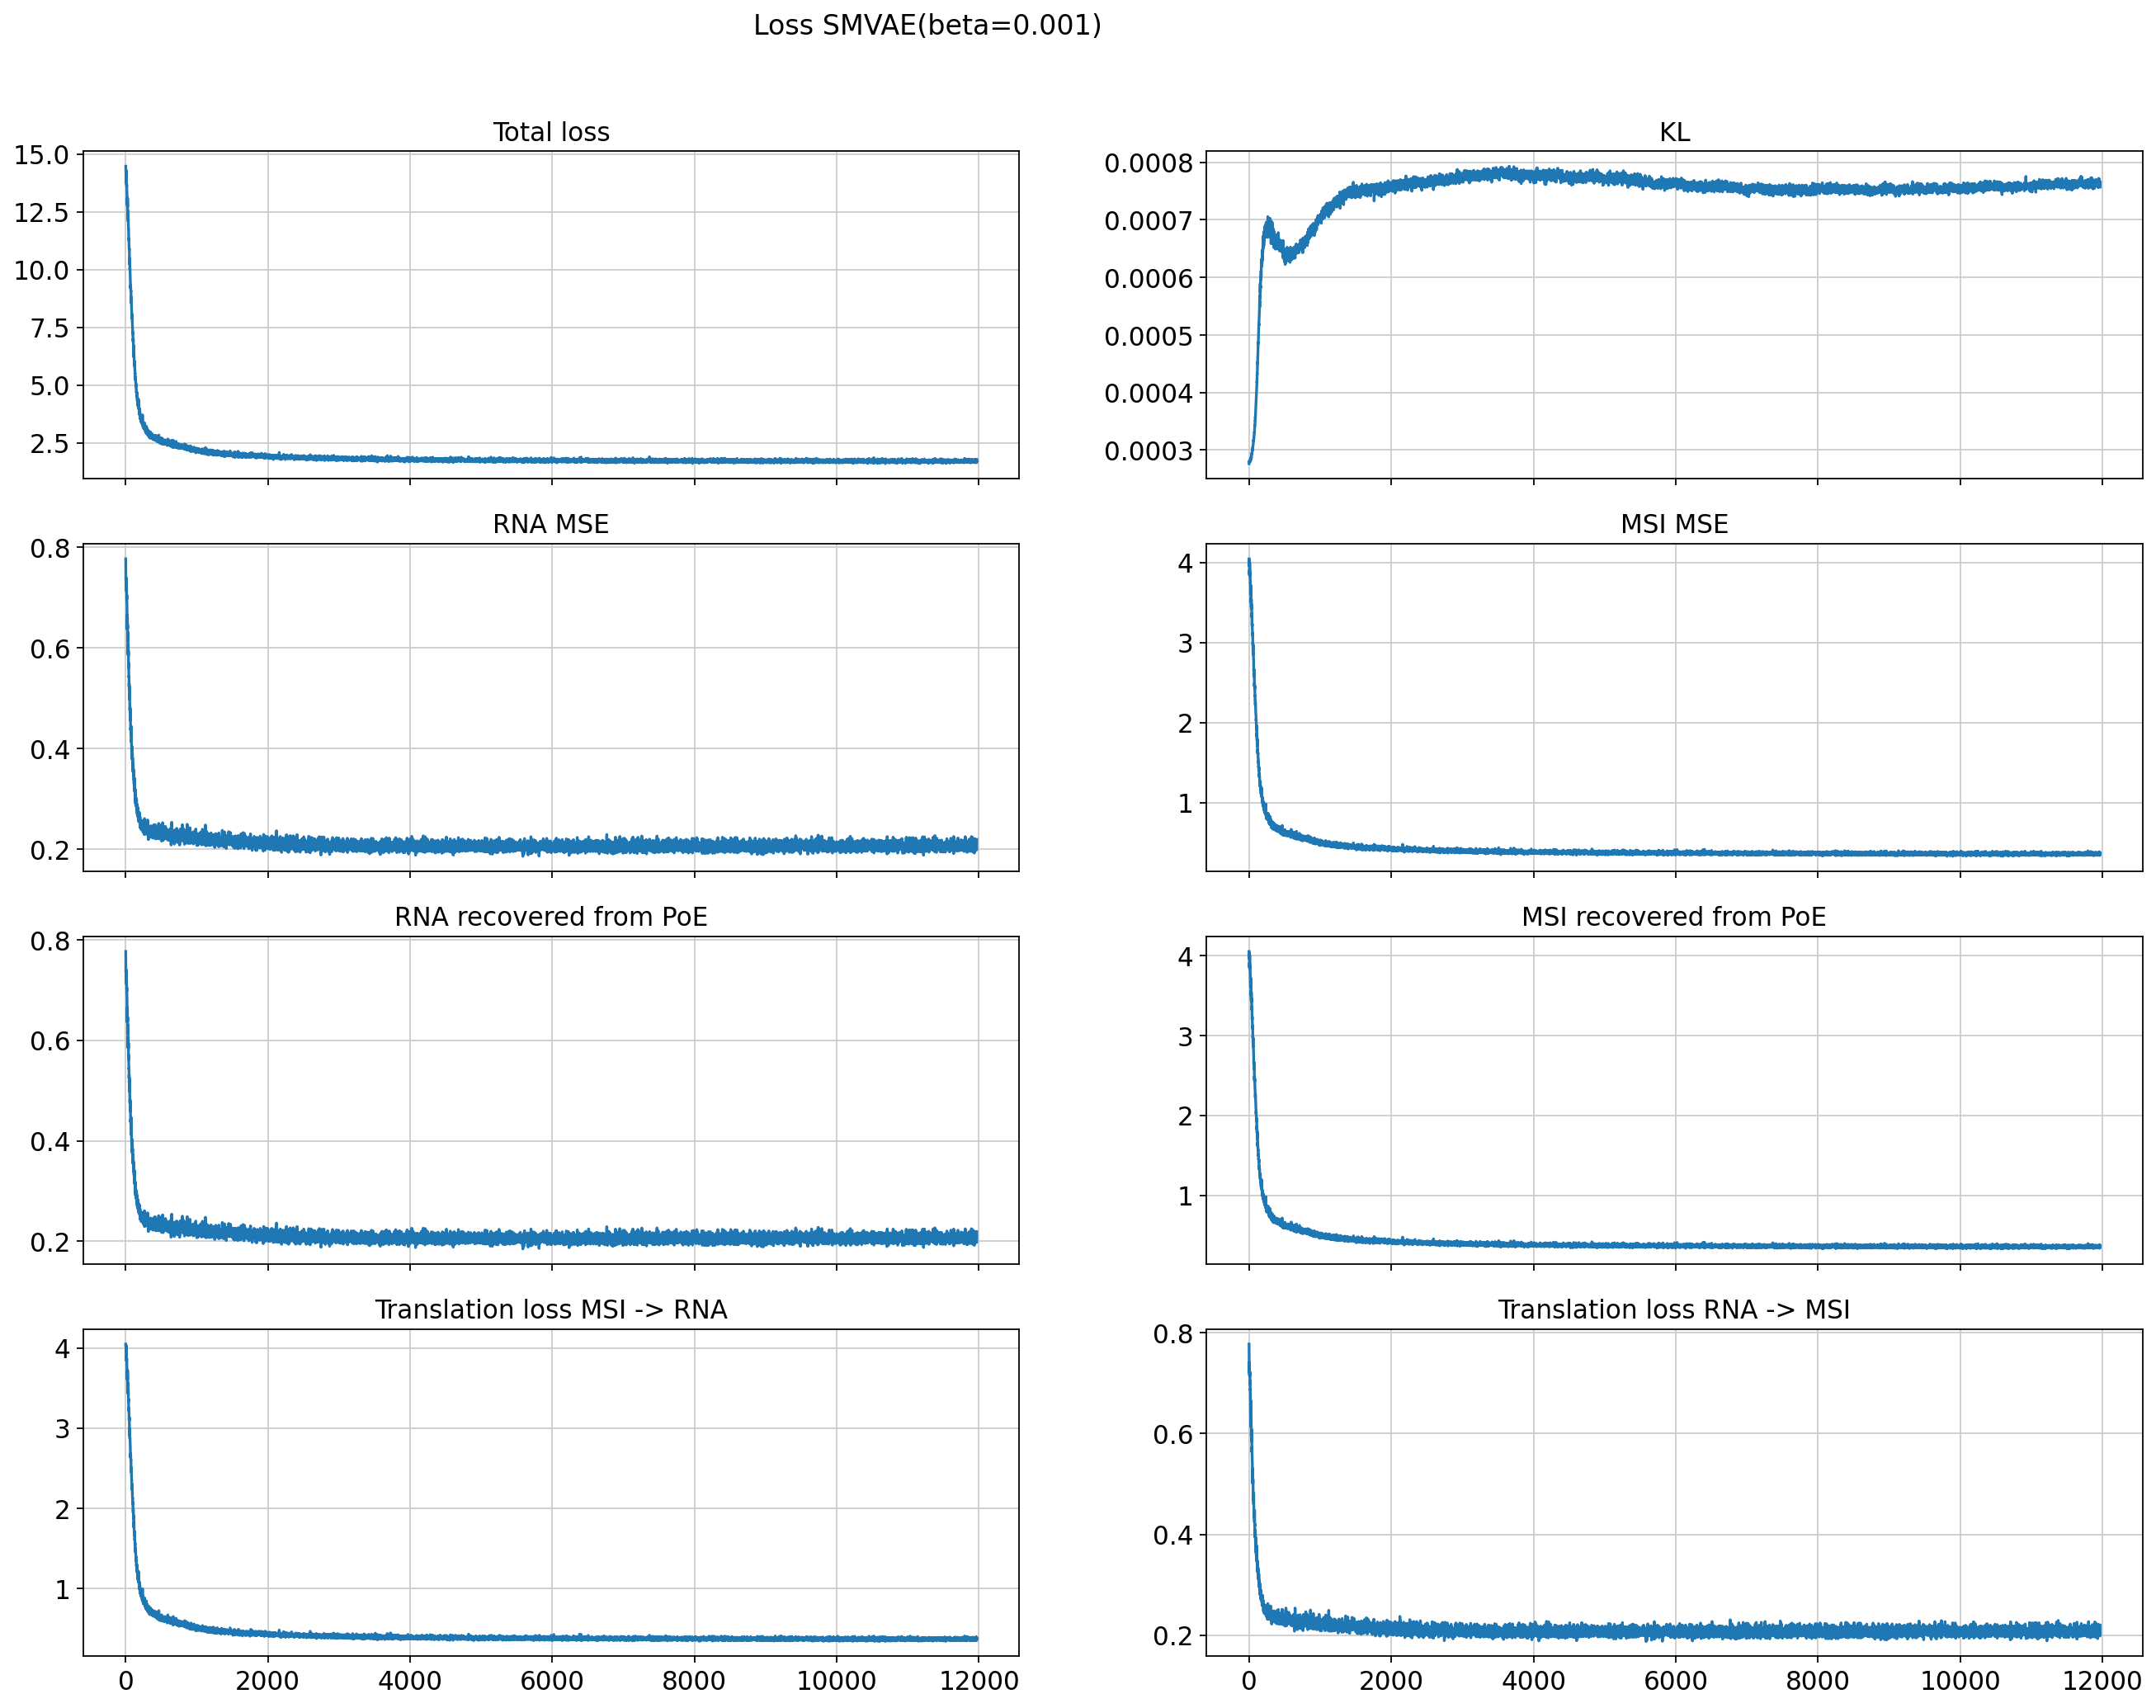

In [188]:
columns = ["PoE_training/total_loss", "PoE_training/kl", 
           "PoE_training/rna_mse", "PoE_training/msi_mse", "PoE_training/recovered_rna_poe", 
           "PoE_training/recovered_msi_poe", "PoE_training/loss_msi_rna", "PoE_training/loss_rna_msi"]
make_plot(runlog_data, columns, "Loss SMVAE(beta=0.001)")